# Causal Inference
## Задание CI.4


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---


**Баллы за задание:**

* Задача 1 — 100 баллов
* Задача 2 — 30 баллов

In [38]:
# Bot check

# HW_ID: ds_ci4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [39]:
# !pip uninstall scipy
# !pip install scipy==1.11

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import causalpy as cp
import warnings
warnings.filterwarnings("ignore")

---
### Задача 1.

Рассмотрим данные Walmart из задачи AB.4.5. Предположим, что сеть небольшая, и состоит только из 45 магазинов, которые представлены в данных. Кроме того, финансовые риски при проведении экспериментов довольно высоки, поэтому для проверки различных инициатив разрешено брать в тестовую группу только один магазин. При этом в компании установлена допустимая вероятность ошибки 1 рода на уровне 20%.

**1.** Пришел заказчик с новой бизнес-инициативой. Выберите один магазин, который вам больше понравится. Помните, чем магазин является более "типичным", тем более надежными будут результаты.

In [41]:
features, stores, train = pd.read_csv('features.csv'), pd.read_csv('stores.csv'), pd.read_csv('train.csv')
for df in [features, stores, train]:
    display(df.head(2))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


,Store,Type,Size
0,1,A,151315
1,2,A,202307


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


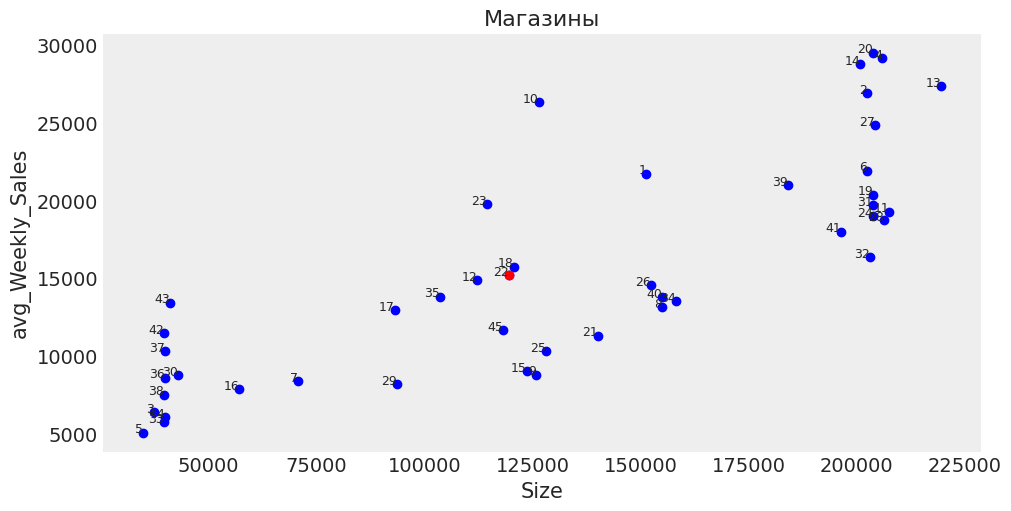

In [42]:
stores['avg_Weekly_Sales'] = train.groupby('Store')['Weekly_Sales'].mean().values
choice = 22
plt.figure(figsize=(10,5))
plt.scatter(stores.Size, stores.avg_Weekly_Sales, color='blue')
plt.scatter(stores.iloc[choice-1].Size, stores.iloc[choice-1].avg_Weekly_Sales, color='red')
for i in stores.index:
    plt.annotate(stores.Store.loc[i], (stores.Size.loc[i], stores.avg_Weekly_Sales.loc[i]), fontsize=9, ha='right')
plt.title('Магазины')
plt.xlabel('Size')
plt.ylabel('avg_Weekly_Sales')
plt.grid()
plt.show()

*"Типичным" представителем кластера обычно называют ближайший к центроиде. Логично выбрать в качестве типичного - 22 (он посередине на графике)*

Заказчик произвел работы в выбранном вами магазине в период 2-3 июня 2012. Добавьте искусственный эффект 5% к этому магазину.

In [43]:
train['Date'] = pd.to_datetime(train['Date'])
train.loc[(train.Store==choice) & (train.Date>pd.Timestamp(day=3, month=6, year=2012)),['Weekly_Sales']] *= 1.05

Оцените эффект с помощью классического diff-in-diff, взяв еще один магазин в качестве контрольного. 

*Примечание.* Для оценки каждого составляющего для надежности стоит брать интервал 4 недели.

In [44]:
control = 18  # очень похож на наш choice
june1, may4 = pd.Timestamp(day=1, month=6, year=2012), pd.Timestamp(day=4, month=5, year=2012)
A = train[(train.Store==choice)  & (train.Date==june1)].Weekly_Sales.mean()
B = train[(train.Store==control) & (train.Date==june1)].Weekly_Sales.mean()
C = train[(train.Store==choice)  & (train.Date==may4)].Weekly_Sales.mean()
D = train[(train.Store==control) & (train.Date==may4)].Weekly_Sales.mean()
print(f'{(A-B) / (C-D):.4f}')

-3.3402


Насколько "визуально" точной получилась оценка? В чем проблема классического diff-in-diff?

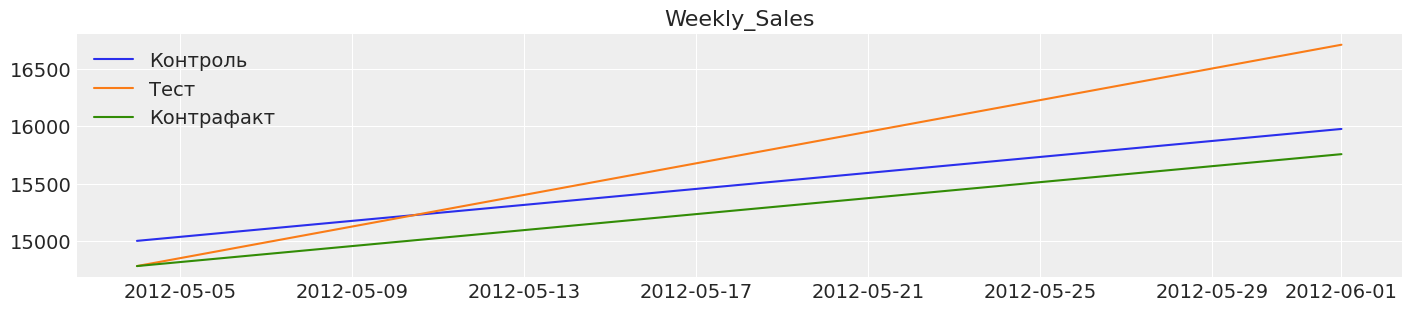

In [45]:
plt.figure(figsize=(14,3))
for y, label in zip([[D,B],[C,A],[C,C+B-D]], ['Контроль','Тест','Контрафакт']):
    plt.plot([may4,june1], y, label=label)
plt.title('Weekly_Sales')
plt.legend()
plt.show()

*Проблема diff-in-diff: предполагаем, что тренд параллелен. В целом, визуально получилось нормально (эффект > 0, график соответствует), но вот сама оценка вышла < 0*

**2.** Перейдем к методу синтетического контроля. Постройте синтетический контроль с помощью линейной регрессии с регуляризацией, оцените эффект и постройте доверительный интервал.

Для обучения линейной регрессии не стоит брать слишком большую историю, достаточно будет 8-9 месяцев.

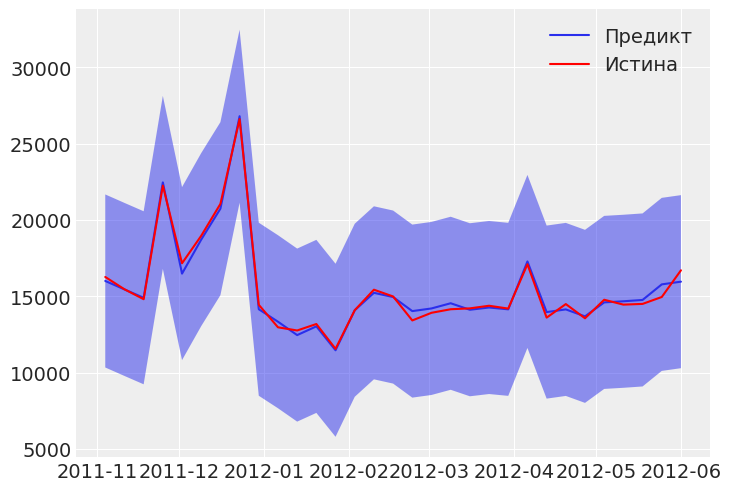

In [46]:
nov1 = pd.Timestamp(day=1, month=11, year=2011)
def get(m=''):
    cond = (train.Date.between(nov1,june1))
    if m=='test':
        cond &= (train.Store!=choice)
    elif m=='':
        cond &= (train.Store==choice)
    return train[cond].groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index().pivot(index='Date',columns='Store',values='Weekly_Sales')

df_train, X_test, X = get('train'), get('test'), get()[choice]
y_pred = Lasso(alpha=1, positive=True).fit(df_train.drop(columns=choice).values, df_train[choice].values).predict(X_test)
plt.plot(X.index, y_pred, label='Предикт')
plt.plot(X.index, X, label='Истина', color='red')
err = (np.percentile(y_pred, 97.5)-np.percentile(y_pred, 2.5))/2
plt.fill_between(X.index, y_pred-err, y_pred+err, alpha=0.5)
plt.legend()
plt.show()

In [47]:
B-y_pred[-1]  # эффект, В определял выше

10.171615791512522

*Теперь получили число >0, прогресс)*

Провалидируйте подход, оценив вероятность ошибки 1 рода и мощность. Для этого стоит произвести достаточное количество итераций метода Монте-Карло, на каждой из которых необходимо
* выбирать случайный магазин в качестве тестового,
* построить для него синтетический контроль,
* оценить его стат. значимость.

Проверьте, имеет ли смысл ставить ограничение на положительность коэффициентов линейной регрессии.

*Примечание.* Используйте параллельные вычисления как в примере с занятия. Желательно произвести не менее $1000$ итераций метода Монте-Карло. Если это занимает слишком долго (больше часа), можно сократить до $500$ итераций.

In [48]:
n_rej = 0
df_train = train[train.Date.between(nov1,june1)].groupby(['Date','Store'])['Weekly_Sales'].mean().reset_index().pivot(index='Date', columns='Store', values='Weekly_Sales')

def calculate_effect(s, model=Lasso(alpha=1, positive=True)):
    X_train, y_train = df_train.drop(columns=s).values, df_train[s].values
    X_test = np.expand_dims(df_train[df_train.index.date>=nov1.date()].drop(columns=s).mean(axis=0).values, axis=0)
    test_after = train[(train.Store==s) & (train.Date==june1)]['Weekly_Sales'].mean()
    return test_after - model.fit(X_train, y_train).predict(X_test)

for i in tqdm(np.random.choice(train.Store.unique(), size=1000)):
    if np.mean(np.array([calculate_effect(j) for j in train.Store.unique() if j!=i]) < calculate_effect(i)) < 0.05:
        n_rej += 1
print(f'{n_rej / 1000:.4f}')

100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]

0.0790


*Провалидировали (на прошлом запуске было <0.05)*

**3.** Заметим, что для получения синтетического контроля более информативными являются те значения обучающей выборки, которые лежат ближе к экспериментальному периоду. Тем самым логично придать им больший вес.

Определите вес $w_i$, линейно возрастающий к началу эксперимента. Например, неделю 8 месяцев назад стоит брать с весом 0, неделю непосредственно перед экспериментом с весом 1.

In [49]:
# !!!

Получаем задачу оптимизации 
$$\begin{cases}
\sum\limits_{i=1}^n w_i (Y_i - x_i^T \theta) + \lambda \|\theta\|^2 \longrightarrow \min\limits_\theta;\\
\theta_1 + ... + \theta_d = 1;\\
\theta_j \geqslant 0, \ j=1,...,d.
\end{cases}$$

Предсказание получается обычным образом как $\widehat{y}(x) = x^T \theta$.

Постройте синтетический контроль с помощью такой задачи оптимизации и провалидируйте его.

*Примечания.*
1. Можно использовать известные пакеты для решения задач оптимизации.
2. На частичный балл можно решить задачу без ограничений по явной формуле.

In [50]:
# !!!

**4.** Простройте синтетический контроль с помощью любой другой модели и провалидируйте его. Например, это может быть прогнозирование временных рядов, причем для прогноза контрафактивного исхода в тестовом магазине можно использовать текущие наблюдаемые исходы в контрольных магазинах. Можно брать любые модели &mdash; линейные, бустинги, нейросети.

In [51]:
n_rej = 0
for i in tqdm(np.random.choice(train.Store.unique(), size=1000)):
    if np.mean(np.array([calculate_effect(j) for j in train.Store.unique() if j!=i]) < calculate_effect(i, model=RandomForestRegressor())) < 0.05:  # RandomForestRegressor
        n_rej += 1
print(f'{n_rej / 1000:.4f}')

100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]

0.0870


*Провалидровали (на прошлом запуске было <0.05)*

**5.** Постройте байесовскую модель синтетического контроля и сравните ее результаты с другими подходами.

In [91]:
df_train.rename(columns={k:f's{k}' for k in df_train.columns}, inplace=True)
formula = f"s{choice} ~ 0 + " + " + ".join([s for s in df_train.columns if s != f's{choice}'])
result = cp.pymc_experiments.SyntheticControl(
    df_train,
    pd.Timestamp(day=1, month=6, year=2012),
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(sample_kwargs={"tune":500,"draws":1000,"target_accept":0.95,"cores":4,"random_seed":42}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 155 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


Сделайте выводы.

*diff-in-diff уступает синтетическому контролю в данной задаче*

---
### Задача 2.

Повторите исследования из задачи CI.3.2 для метода инструментальных признаков, генерируя два типа данных:
* тритмент, таргет, инструмент;
* тритмент, таргет, инструмент, конфаундер.

Мы предполагаем, что конфаундер ненаблюдаем. В этих условиях сравните метод инструментальных признаков с простым t-test.